In [4]:
# this notebook will use decision transformer in offline reinforcement learning setting to create bot for trading stock

# import utility libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# import gym library
import gym
import gym_anytrading
from gym_anytrading.envs import StocksEnv

# import helper functions on getting stock data
from getstock import get_stock_data_yf

# import Technical Analysis functions
from ta.trend import SMAIndicator
from ta.momentum import RSIIndicator
from ta.volume import OnBalanceVolumeIndicator

In [2]:
# get apple stock data
stock_data = get_stock_data_yf('AAPL', 2, '1d')

# initialize the technical indicators
sma = SMAIndicator(close=stock_data['Close'], window=12, fillna=True)
rsi = RSIIndicator(stock_data['Close'], window=12, fillna=True)
obv = OnBalanceVolumeIndicator(stock_data['Close'], stock_data['Volume'], fillna=True)

# add custom indicators to the stock data
stock_data['SMA'] = sma.sma_indicator()
stock_data['RSI'] = rsi.rsi()
stock_data['OBV'] = obv.on_balance_volume()

[*********************100%***********************]  1 of 1 completed


In [3]:
# show the last 15 rows of the stock data with the custom indicators
stock_data.tail(15)

,Open,High,Low,Close,Adj Close,Volume,SMA,RSI,OBV
Date,,,,,,,,,
2022-10-10,140.419998,141.889999,138.570007,140.419998,140.419998,74899000,145.364164,35.265022,-446590800
2022-10-11,139.899994,141.350006,138.220001,138.979996,138.979996,77033700,144.409997,33.606169,-523624500
2022-10-12,139.130005,140.360001,138.160004,138.339996,138.339996,70433700,143.374163,32.856803,-594058200
2022-10-13,134.990005,143.589996,134.369995,142.990005,142.990005,113224000,142.643331,42.941407,-480834200
2022-10-14,144.309998,144.520004,138.190002,138.380005,138.380005,88512300,141.688332,36.940756,-569346500
2022-10-17,141.070007,142.899994,140.270004,142.410004,142.410004,85250900,141.682499,44.356113,-484095600
2022-10-18,145.490005,146.699997,140.610001,143.750000,143.750000,99136600,142.144999,46.632506,-384959000
2022-10-19,141.690002,144.949997,141.500000,143.860001,143.860001,61758300,142.262499,46.827311,-323200700
2022-10-20,143.020004,145.889999,142.649994,143.389999,143.389999,64522000,142.036666,46.043905,-387722700


In [41]:
# helper function to add the custom indicators to the environment
def add_signals(env):
    start = env.frame_bound[0] - env.window_size
    end = env.frame_bound[1]
    prices = env.df.loc[:, 'Low'].to_numpy()[start:end]
    signal_features = env.df.loc[:, ['Low','Volume','SMA', 'RSI', 'OBV']].to_numpy()[start:end]
    return prices, signal_features

# create the custom environment with signal features
class CustomStockEnv(StocksEnv):
    _process_data = add_signals

custenv = CustomStockEnv(df=stock_data, window_size=1, frame_bound=(1, 20))


action: 0, reward: 0, done: False, info: {'total_reward': 0.0, 'total_profit': 1.0, 'position': 0}
action: 0, reward: 0, done: False, info: {'total_reward': 0.0, 'total_profit': 1.0, 'position': 0}
action: 0, reward: 0, done: False, info: {'total_reward': 0.0, 'total_profit': 1.0, 'position': 0}
action: 1, reward: 0, done: False, info: {'total_reward': 0.0, 'total_profit': 1.0, 'position': 1}
action: 1, reward: 0, done: False, info: {'total_reward': 0.0, 'total_profit': 1.0, 'position': 1}
Box(-inf, inf, (12, 5), float64)


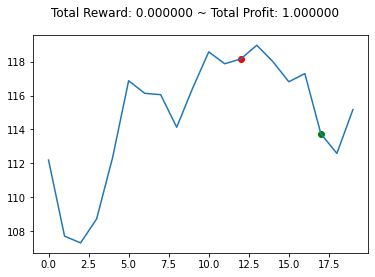

None


In [57]:
custenv.reset()
# sample actions from the action space
for i in range(5):
    actions = custenv.action_space.sample()
    state, reward, done, info = custenv.step(actions)
    print(f"action: {actions}, reward: {reward}, done: {done}, info: {info}")
print(custenv.observation_space)

print(custenv.render())

In [ ]:
# create datasets of state, action, reward for offline reinforcement learning by sampling the environment with random actions for 
def create_dataset(env, n_steps):
    dataset = []
    for i in range(n_steps):
        action = np.random.randint(0, env.action_space.n)
        obs, reward, done, _ = env.step(action)
        dataset.append((obs, action, reward))
        if done:
            break
    return dataset